# Synthetic Controls Comparison Data Analysis 

In [2]:
%%capture
# Capture suppresses output to screen
import stata_setup
stata_setup.config("/Applications/Stata 17", "be")

In [3]:
%%stata
/* Define input and output paths */
global data "Data"
global output "Output"
global graphs "$output/Graphs"
global tables "$output/Tables"

global processed "$data/Processed"

global finalSynthData "$processed/finalSynth.dta"


. /* Define input and output paths */
. global data "Data"

. global output "Output"

. global graphs "$output/Graphs"

. global tables "$output/Tables"

. 
. global processed "$data/Processed"

. 
. global finalSynthData "$processed/finalSynth.dta"

. 


In [4]:
%%capture
%%stata
log using "$output/analysis-Syth.log", replace

## Read in Master Data File

In [5]:
%%stata
use "$finalSynthData", clear
describe


. use "$finalSynthData", clear

. describe

Contains data from Data/Processed/finalSynth.dta
 Observations:           646                  
    Variables:            24                  5 Feb 2022 19:04
-------------------------------------------------------------------------------
Variable      Storage   Display    Value
    name         type    format    label      Variable label
-------------------------------------------------------------------------------
year            float   %10.0g                Year
employment      long    %10.0g                Annual Reported Employment (NAICS
                                                3364)
state           str2    %9s                   
annualPay       long    %10.0g                Average Annual Pay (USD) (NAICS
                                                3364)
lnEmployment    float   %9.0g                 
lnAnnualPay     float   %9.0g                 
unemploy        double  %10.0g                Annual state level unemploymen

## Evaluate missing values in the data

In [6]:
%%stata
misstable summarize employment annualPay pop unemploy

                                                             Obs<.
                                                +------------------------------
               |                                | Unique
      Variable |     Obs=.     Obs>.     Obs<.  | values        Min         Max
  -------------+--------------------------------+------------------------------
    employment |         4                 642  |   >500        452       96012
     annualPay |         4                 642  |   >500      34951      138768
  -----------------------------------------------------------------------------


In [7]:
%%stata
list year state employment annualPay ///
    if employment==. | annualPay==.


. list year state employment annualPay ///
>     if employment==. | annualPay==.

     +------------------------------------+
     | year   state   employ~t   annual~y |
     |------------------------------------|
495. | 2001      SC          .          . |
496. | 2002      SC          .          . |
497. | 2003      SC          .          . |
498. | 2004      SC          .          . |
     +------------------------------------+

. 


In [8]:
%%stata
list year employment annualPay if state=="SC"


     +----------------------------+
     | year   employ~t   annual~y |
     |----------------------------|
495. | 2001          .          . |
496. | 2002          .          . |
497. | 2003          .          . |
498. | 2004          .          . |
499. | 2005        452      61448 |
     |----------------------------|
500. | 2006        515      63420 |
501. | 2007        866      67915 |
502. | 2008       1365      66607 |
503. | 2009       1917      68722 |
504. | 2010       2993      72933 |
     |----------------------------|
505. | 2011       4534      76650 |
506. | 2012       5867      74753 |
507. | 2013       6531      80758 |
508. | 2014       7002      91915 |
509. | 2015       7340      86881 |
     |----------------------------|
510. | 2016       7920      86006 |
511. | 2017       7631      86249 |
512. | 2018       7178      93363 |
513. | 2019       7381     100039 |
     +----------------------------+


## Drop data prior to 2001-2004 
South Carolina had not significant NAICS 3364 industry prior to 2005 but has
as significant industry in period afterwards.

Treatment period of interest is 2014. 

In [9]:
%%stata
drop if year < 2005

(136 observations deleted)


## Generate Summary Statistics for WA

In [10]:
%%stata
estpost summarize employment annualPay unemploy pop if state=="WA", quietly
eststo waSum

/* For Display */
esttab waSum, ///
    noobs nonumbers ///
    cells( (mean(label("Mean")) min(label("Min")) max(label("Max")) ///
            count(label("Num Obs"))) /// 
          (sd(par label("SD")) ) ) ///
    coeflabels(employment "Annual Employment" ///
              annualPay "Annual Pay" ///
              unemploy "Annual Unemployment Rate" ///
              pop "Est Population") ///
    mtitles("WA") ///
    addnotes("Standard Deviations in paranthesis" "NAICS 3364 for years 2005-2019")
    
/* For Ouput */
esttab waSum using $tables/waSum.tex, ///
    replace ///
    noobs nonumbers ///
    cells( (mean(label("Mean")) min(label("Min")) max(label("Max")) ///
            count(label("Num Obs"))) /// 
          (sd(par label("SD")) ) ) ///
    coeflabels(employment "Annual Employment" ///
              annualPay "Annual Pay" ///
              unemploy "Annual Unemployment Rate" ///
              pop "Est Population") ///
    mtitles("WA") ///
    addnotes("Standard Deviations in paranthesis" "NAICS 3364 for years 2005-2019")


. estpost summarize employment annualPay unemploy pop if state=="WA", quietly

. eststo waSum

. 
. /* For Display */
. esttab waSum, ///
>     noobs nonumbers ///
>     cells( (mean(label("Mean")) min(label("Min")) max(label("Max")) ///
>             count(label("Num Obs"))) /// 
>           (sd(par label("SD")) ) ) ///
>     coeflabels(employment "Annual Employment" ///
>               annualPay "Annual Pay" ///
>               unemploy "Annual Unemployment Rate" ///
>               pop "Est Population") ///
>     mtitles("WA") ///
>     addnotes("Standard Deviations in paranthesis" "NAICS 3364 for years 2005-
> 2019")

----------------------------------------------------------------
                       WA                                       
                  Mean/SD          Min          Max      Num Obs
----------------------------------------------------------------
Annual Emp~t      85144.6        65616        96012           15
                 (8368.6)                   

---

## Run synthetic control analysis

In [11]:
%%stata
list fips state if state=="WA"


     +--------------+
     | fips   state |
     |--------------|
466. |   53      WA |
467. |   53      WA |
468. |   53      WA |
469. |   53      WA |
470. |   53      WA |
     |--------------|
471. |   53      WA |
472. |   53      WA |
473. |   53      WA |
474. |   53      WA |
475. |   53      WA |
     |--------------|
476. |   53      WA |
477. |   53      WA |
478. |   53      WA |
479. |   53      WA |
480. |   53      WA |
     +--------------+


## Growth Rates


. /* WA State is the treatment state.  WA is fips==53 */
. synth lnEmployment ///
>     lnEmployment(2010) lnEmployment(2011) lnEmployment(2012) lnEmployment(201
> 3) ///
>     lnAnnualPay(2010) lnAnnualPay(2011) lnAnnualPay(2012) lnAnnualPay(2013) /
> //
>     lnUnemploy(2010) lnUnemploy(2011) lnUnemploy(2012) lnUnemploy(2013) ///
>     lnPop(2010) lnPop(2011) lnPop(2012) lnPop(2013), ///
>     trunit(53) trperiod(2014) unitnames(state) ///
>     msperiod(2005(1)2013) resultsperiod(2005(1)2019) replace figure
-------------------------------------------------------------------------------
Synthetic Control Method for Comparative Case Studies
-------------------------------------------------------------------------------

First Step: Data Setup
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Data Setup successful
---------------------------------------------------------------

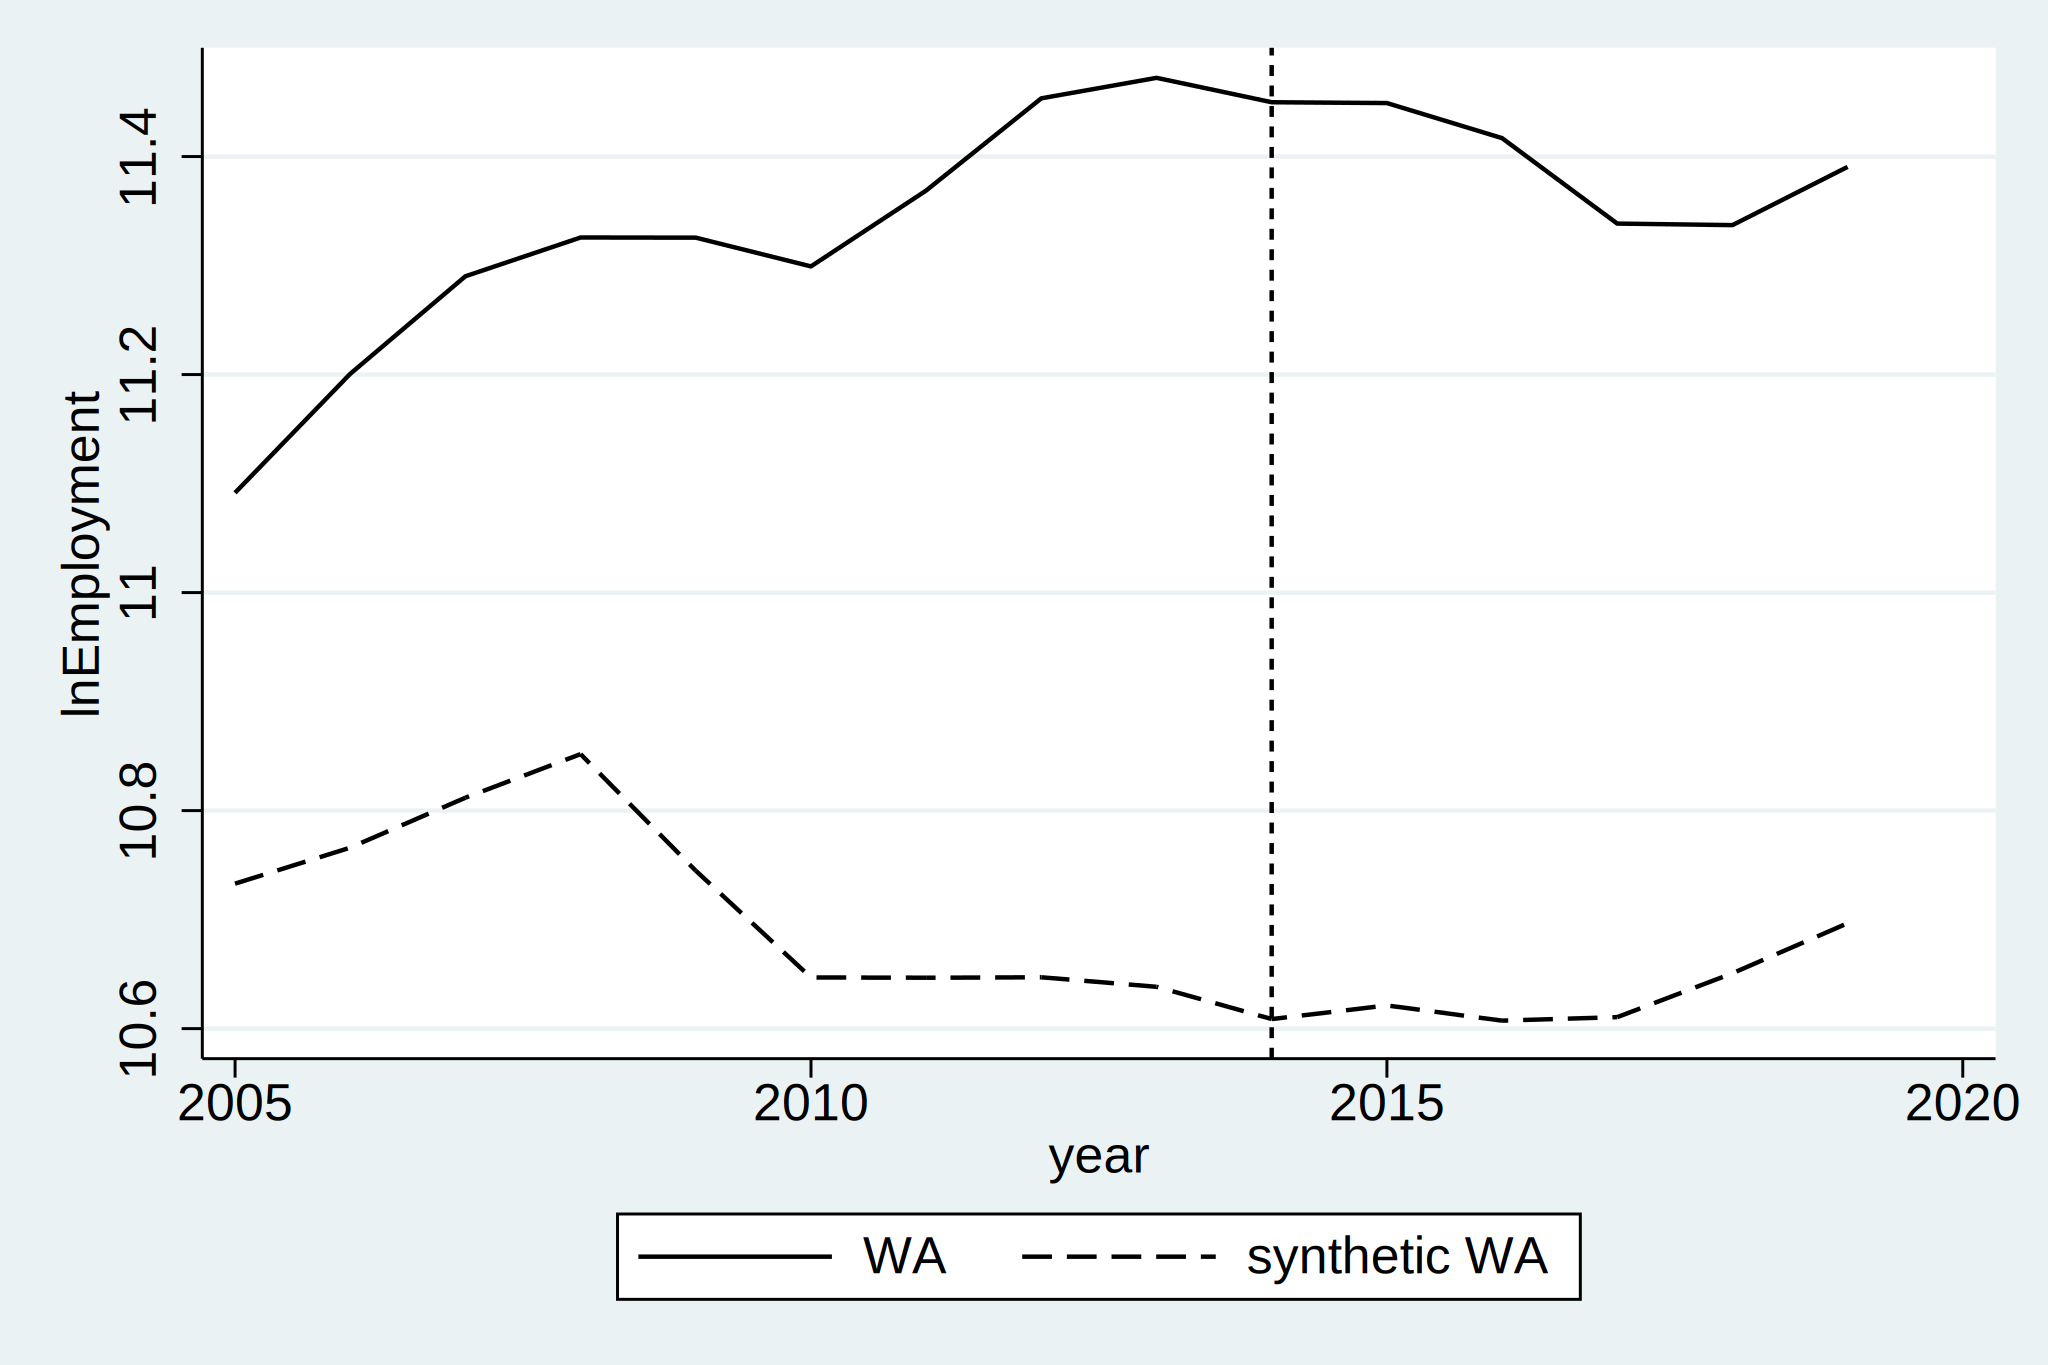

In [12]:
%%stata
/* WA State is the treatment state.  WA is fips==53 */
synth lnEmployment ///
    lnEmployment(2010) lnEmployment(2011) lnEmployment(2012) lnEmployment(2013) ///
    lnAnnualPay(2010) lnAnnualPay(2011) lnAnnualPay(2012) lnAnnualPay(2013) ///
    lnUnemploy(2010) lnUnemploy(2011) lnUnemploy(2012) lnUnemploy(2013) ///
    lnPop(2010) lnPop(2011) lnPop(2012) lnPop(2013), ///
    trunit(53) trperiod(2014) unitnames(state) ///
    msperiod(2005(1)2013) resultsperiod(2005(1)2019) replace figure


. /* Rename Graph */
. graph rename Graph synthWaEmploymentLn, replace
(note: graph synthWaEmploymentLn not found)

. 
. /*  Show the graph from the command above */
. graph display

. 


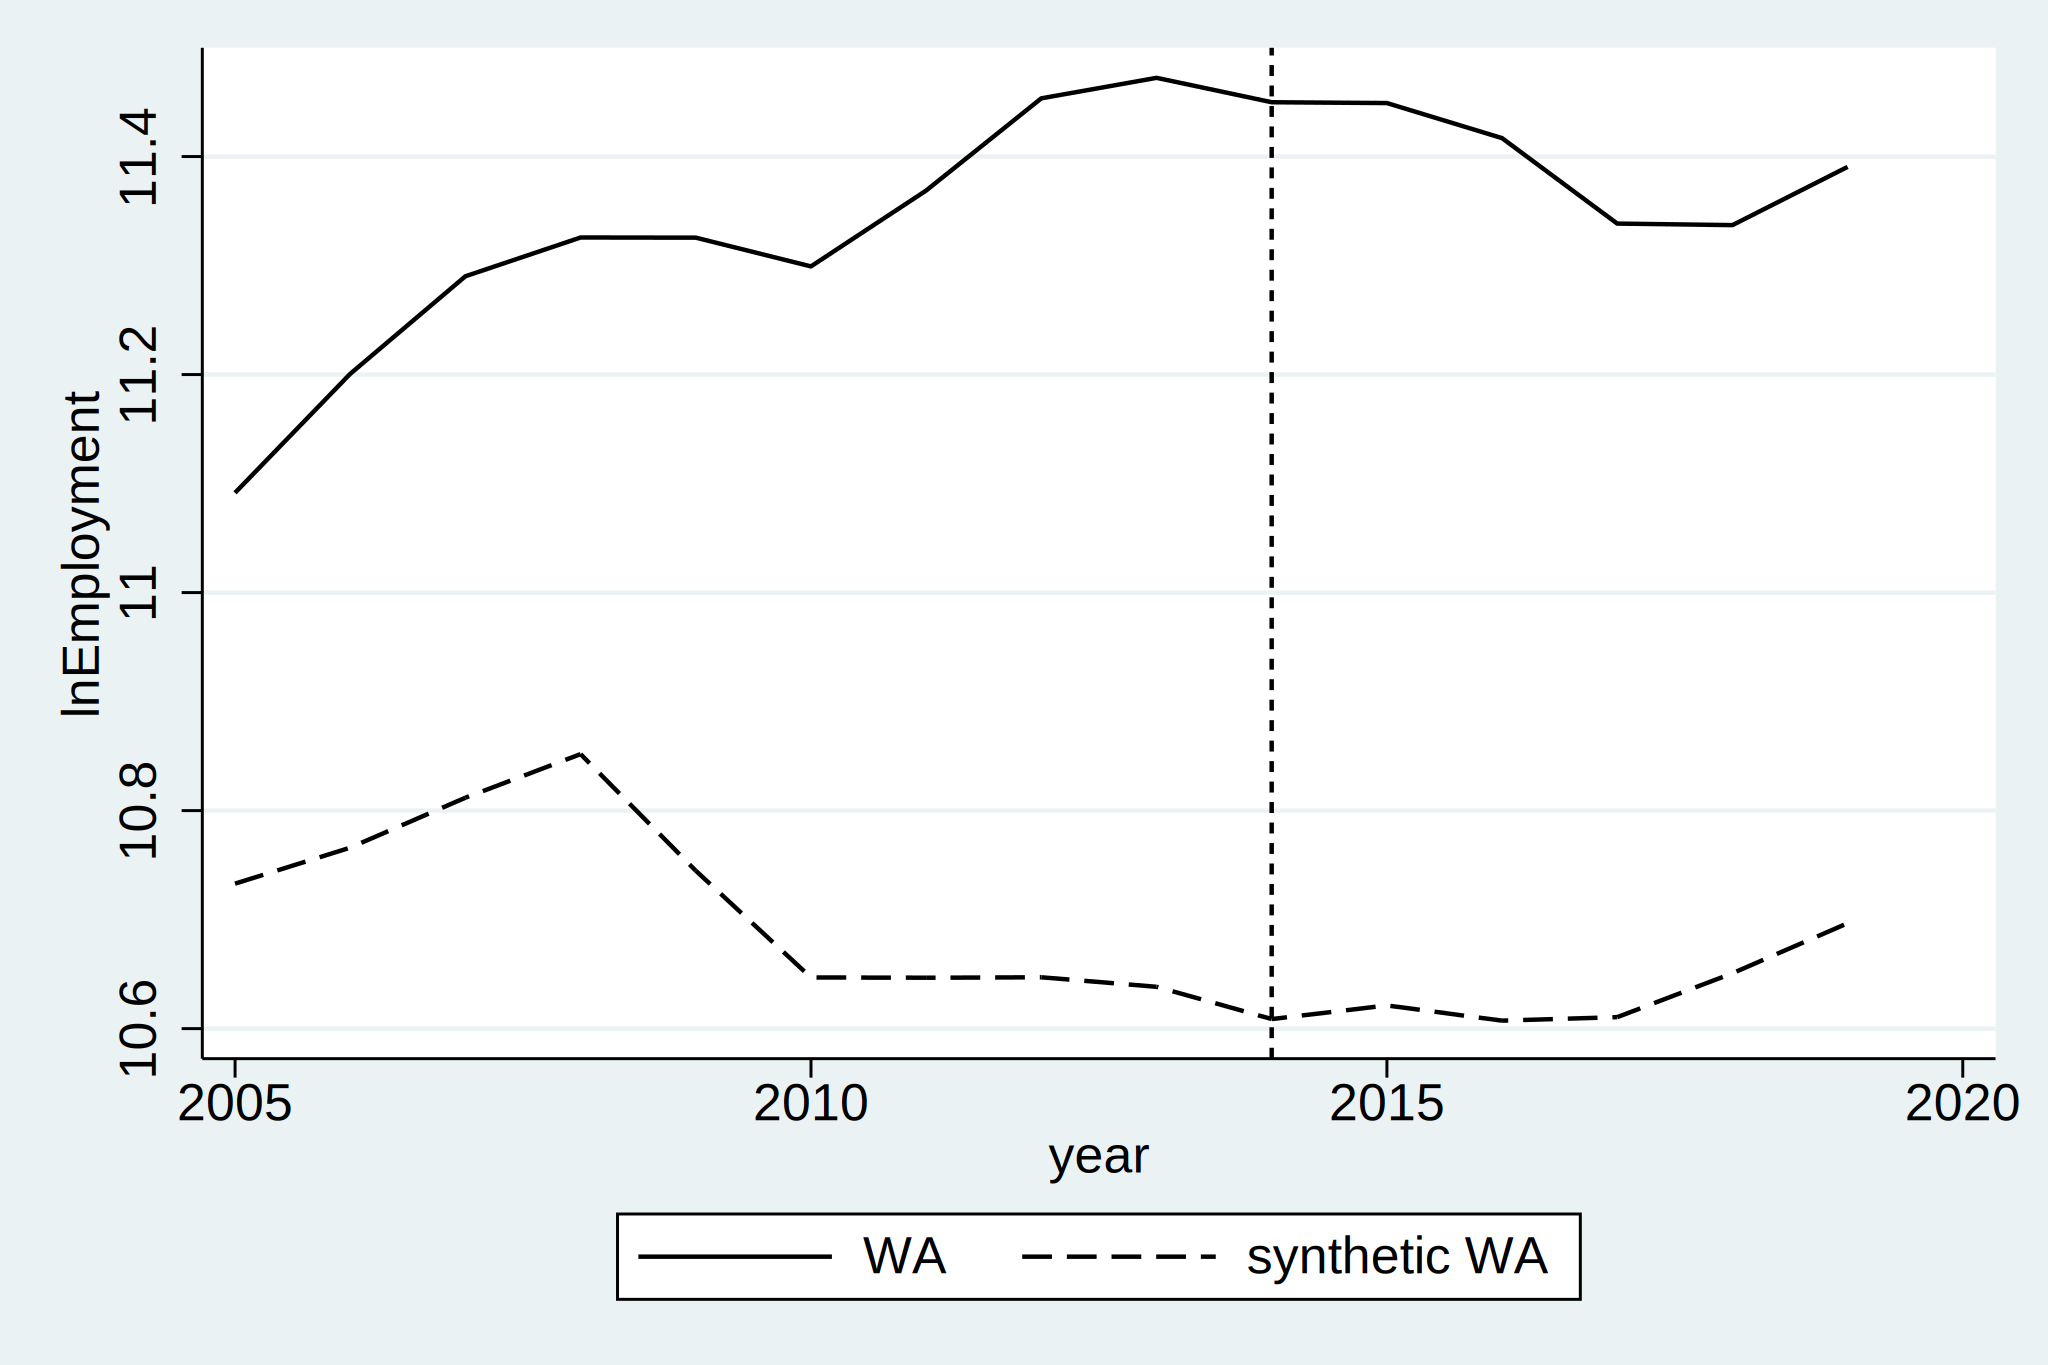

In [13]:
%%stata
/* Rename Graph */
graph rename Graph synthWaEmploymentLn, replace

/*  Show the graph from the command above */
graph display


. synth lnAnnualPay ///
>     lnEmployment(2010) lnEmployment(2011) lnEmployment(2012) lnEmployment(201
> 3) ///
>     lnAnnualPay(2010) lnAnnualPay(2011) lnAnnualPay(2012) lnAnnualPay(2013) /
> //
>     lnUnemploy(2010) lnUnemploy(2011) lnUnemploy(2012) lnUnemploy(2013) ///
>     lnPop(2010) lnPop(2011) lnPop(2012) lnPop(2013), ///
>     trunit(53) trperiod(2014) unitnames(state) ///
>     msperiod(2005(1)2013) resultsperiod(2005(1)2019) ///
>     replace ///
>     figure
-------------------------------------------------------------------------------
Synthetic Control Method for Comparative Case Studies
-------------------------------------------------------------------------------

First Step: Data Setup
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Data Setup successful
-------------------------------------------------------------------------------
                Treat

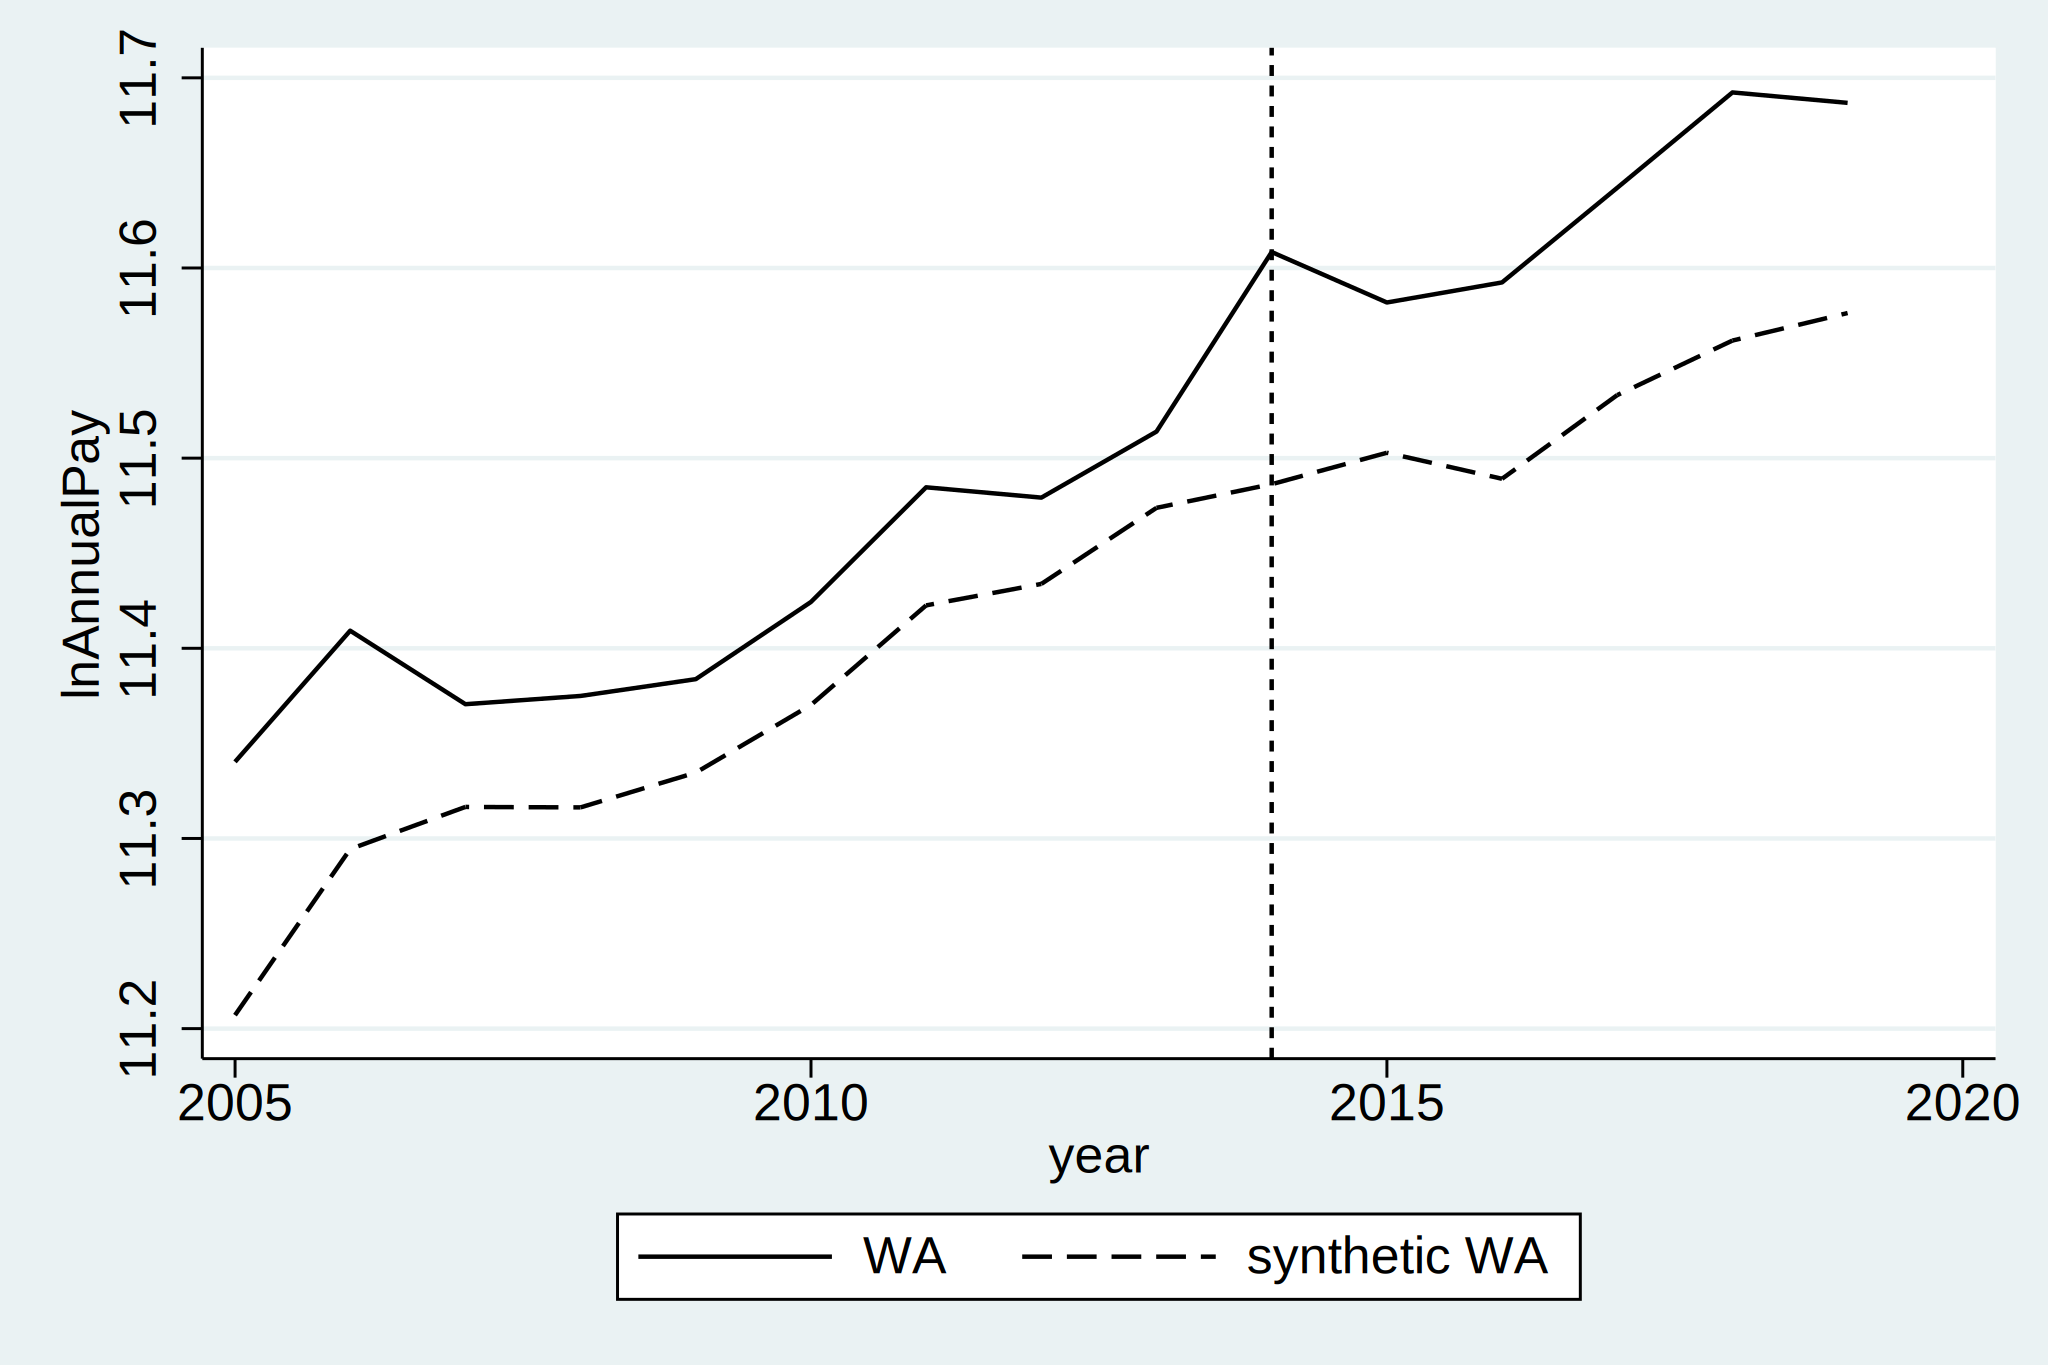

In [14]:
%%stata
synth lnAnnualPay ///
    lnEmployment(2010) lnEmployment(2011) lnEmployment(2012) lnEmployment(2013) ///
    lnAnnualPay(2010) lnAnnualPay(2011) lnAnnualPay(2012) lnAnnualPay(2013) ///
    lnUnemploy(2010) lnUnemploy(2011) lnUnemploy(2012) lnUnemploy(2013) ///
    lnPop(2010) lnPop(2011) lnPop(2012) lnPop(2013), ///
    trunit(53) trperiod(2014) unitnames(state) ///
    msperiod(2005(1)2013) resultsperiod(2005(1)2019) ///
    replace ///
    figure


. /* Rename Graph */
. graph rename Graph synthWaAnnualPayLn, replace
(note: graph synthWaAnnualPayLn not found)

. 
. /*  Show the graph from the command above */
. graph display

. 


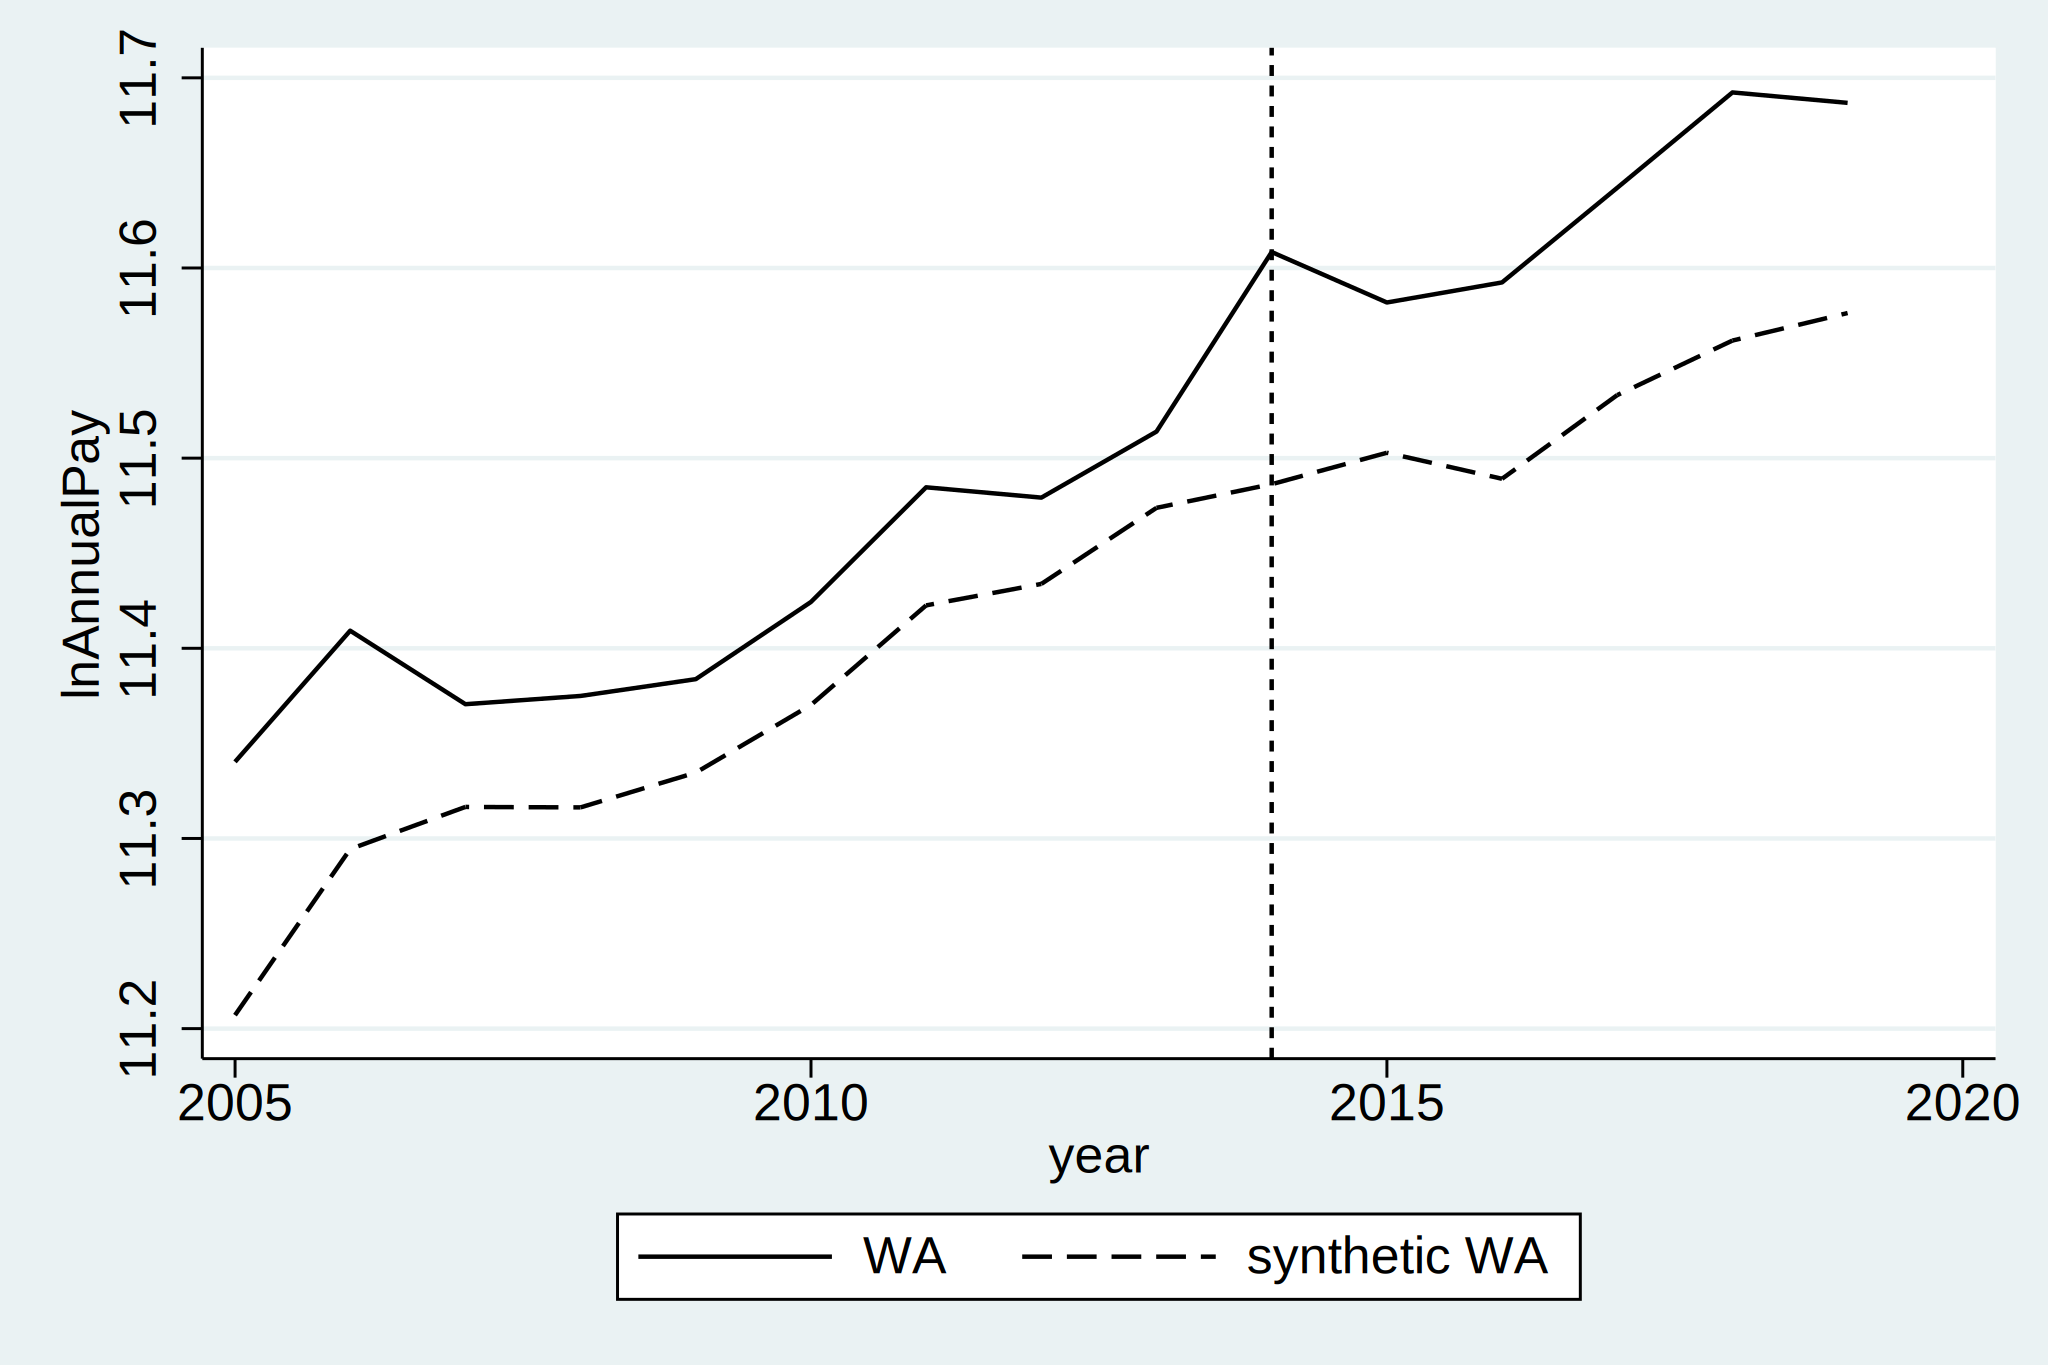

In [15]:
%%stata
/* Rename Graph */
graph rename Graph synthWaAnnualPayLn, replace

/*  Show the graph from the command above */
graph display

## Levels


. /* WA State is the treatment state.  WA is fips==53 */
. synth employment ///
>     employment(2010) employment(2011) employment(2012) employment(2013) ///
>     annualPay(2010) annualPay(2011) lnAnnualPay(2012) annualPay(2013) ///
>     unemploy(2010) unemploy(2011) unemploy(2012) unemploy(2013) ///
>     pop(2010) pop(2011) pop(2012) pop(2013), ///
>     trunit(53) trperiod(2014) unitnames(state) ///
>     msperiod(2005(1)2013) resultsperiod(2005(1)2019) ///
>     replace ///
>     figure
-------------------------------------------------------------------------------
Synthetic Control Method for Comparative Case Studies
-------------------------------------------------------------------------------

First Step: Data Setup
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Data Setup successful
-------------------------------------------------------------------------------
 

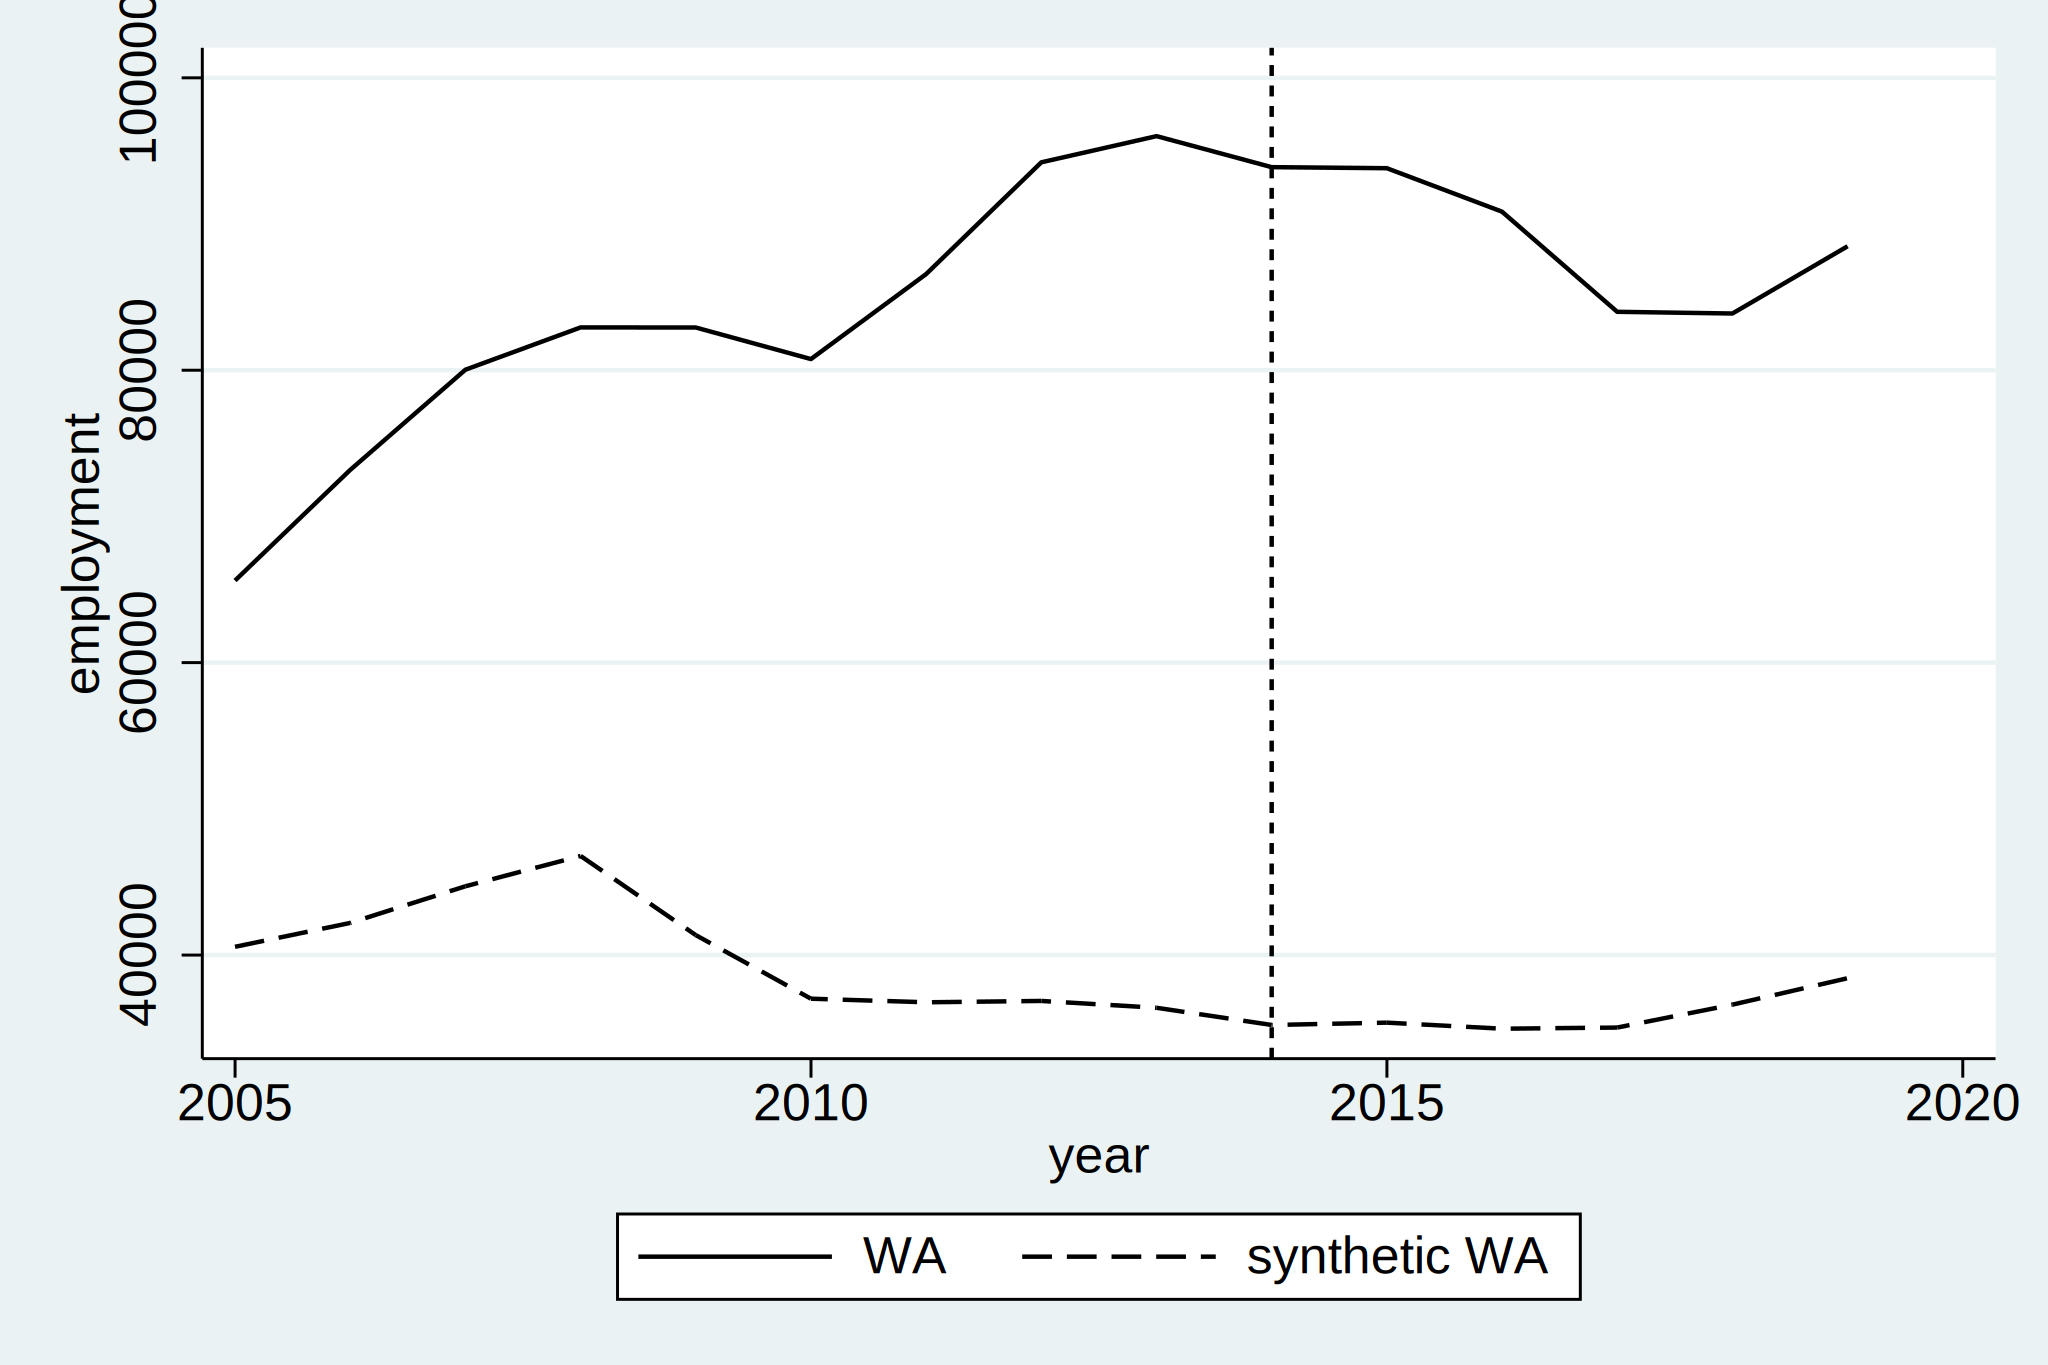

In [16]:
%%stata
/* WA State is the treatment state.  WA is fips==53 */
synth employment ///
    employment(2010) employment(2011) employment(2012) employment(2013) ///
    annualPay(2010) annualPay(2011) lnAnnualPay(2012) annualPay(2013) ///
    unemploy(2010) unemploy(2011) unemploy(2012) unemploy(2013) ///
    pop(2010) pop(2011) pop(2012) pop(2013), ///
    trunit(53) trperiod(2014) unitnames(state) ///
    msperiod(2005(1)2013) resultsperiod(2005(1)2019) ///
    replace ///
    figure


. /* Rename Graph */
. graph rename Graph synthWaEmploymentLvl, replace
(note: graph synthWaEmploymentLvl not found)

. 
. /*  Show the graph from the command above */
. graph display

. 


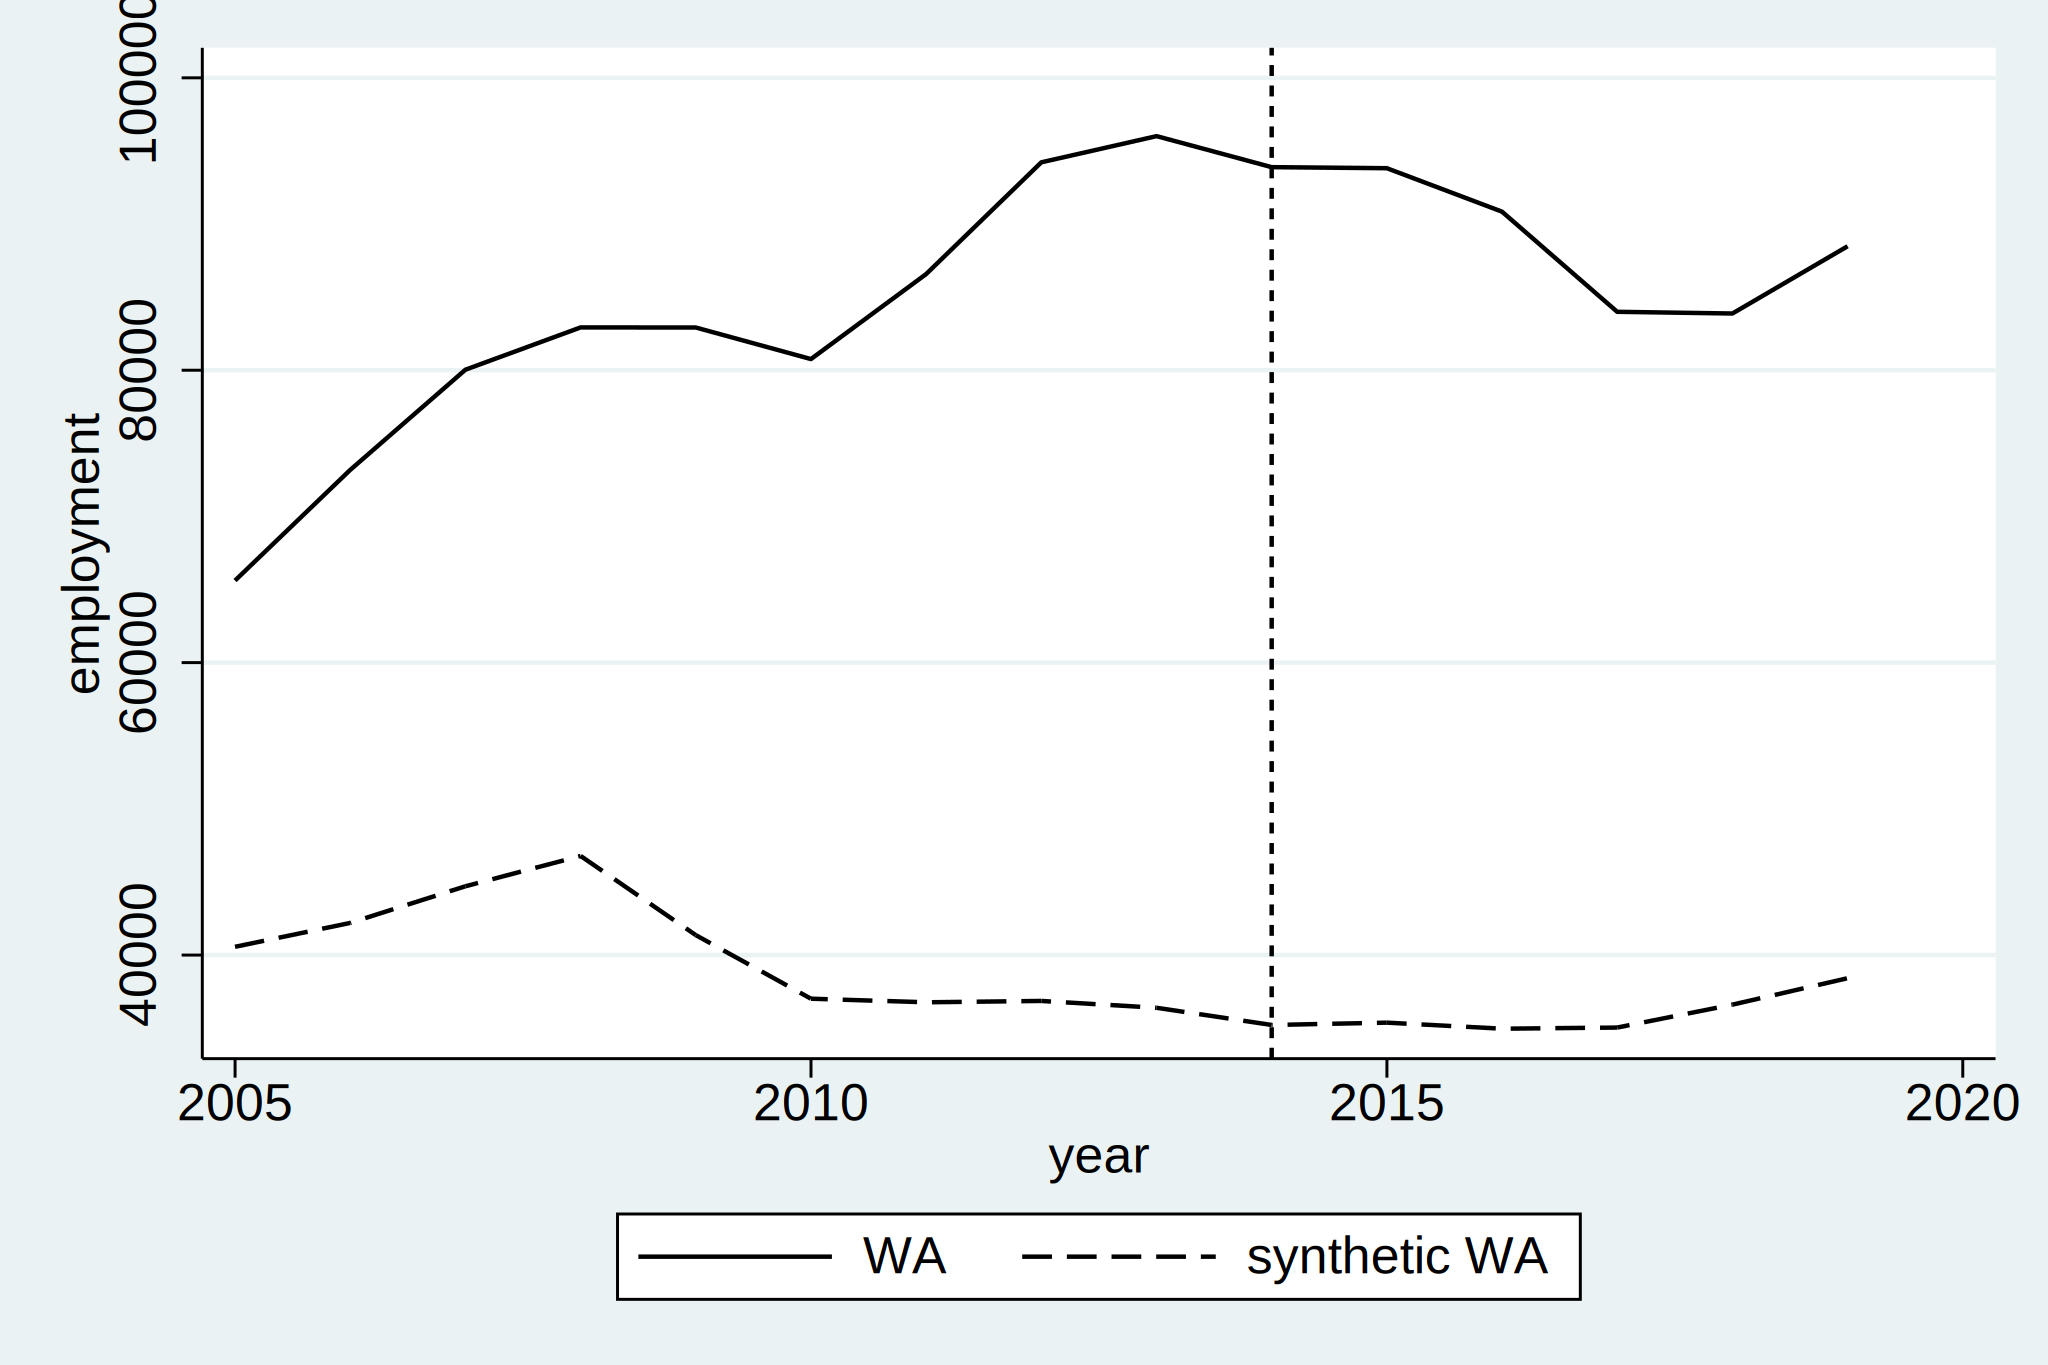

In [17]:
%%stata
/* Rename Graph */
graph rename Graph synthWaEmploymentLvl, replace

/*  Show the graph from the command above */
graph display


. synth annualPay ///
>     employment(2010) employment(2011) employment(2012) employment(2013) ///
>     annualPay(2010) annualPay(2011) lnAnnualPay(2012) annualPay(2013) ///
>     unemploy(2010) unemploy(2011) unemploy(2012) unemploy(2013) ///
>     pop(2010) pop(2011) pop(2012) pop(2013), ///
>     trunit(53) trperiod(2014) unitnames(state) ///
>     msperiod(2005(1)2013) resultsperiod(2005(1)2019) /// 
>     replace ///
>     figure
-------------------------------------------------------------------------------
Synthetic Control Method for Comparative Case Studies
-------------------------------------------------------------------------------

First Step: Data Setup
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Data Setup successful
-------------------------------------------------------------------------------
                Treated Unit: WA
               Control Un

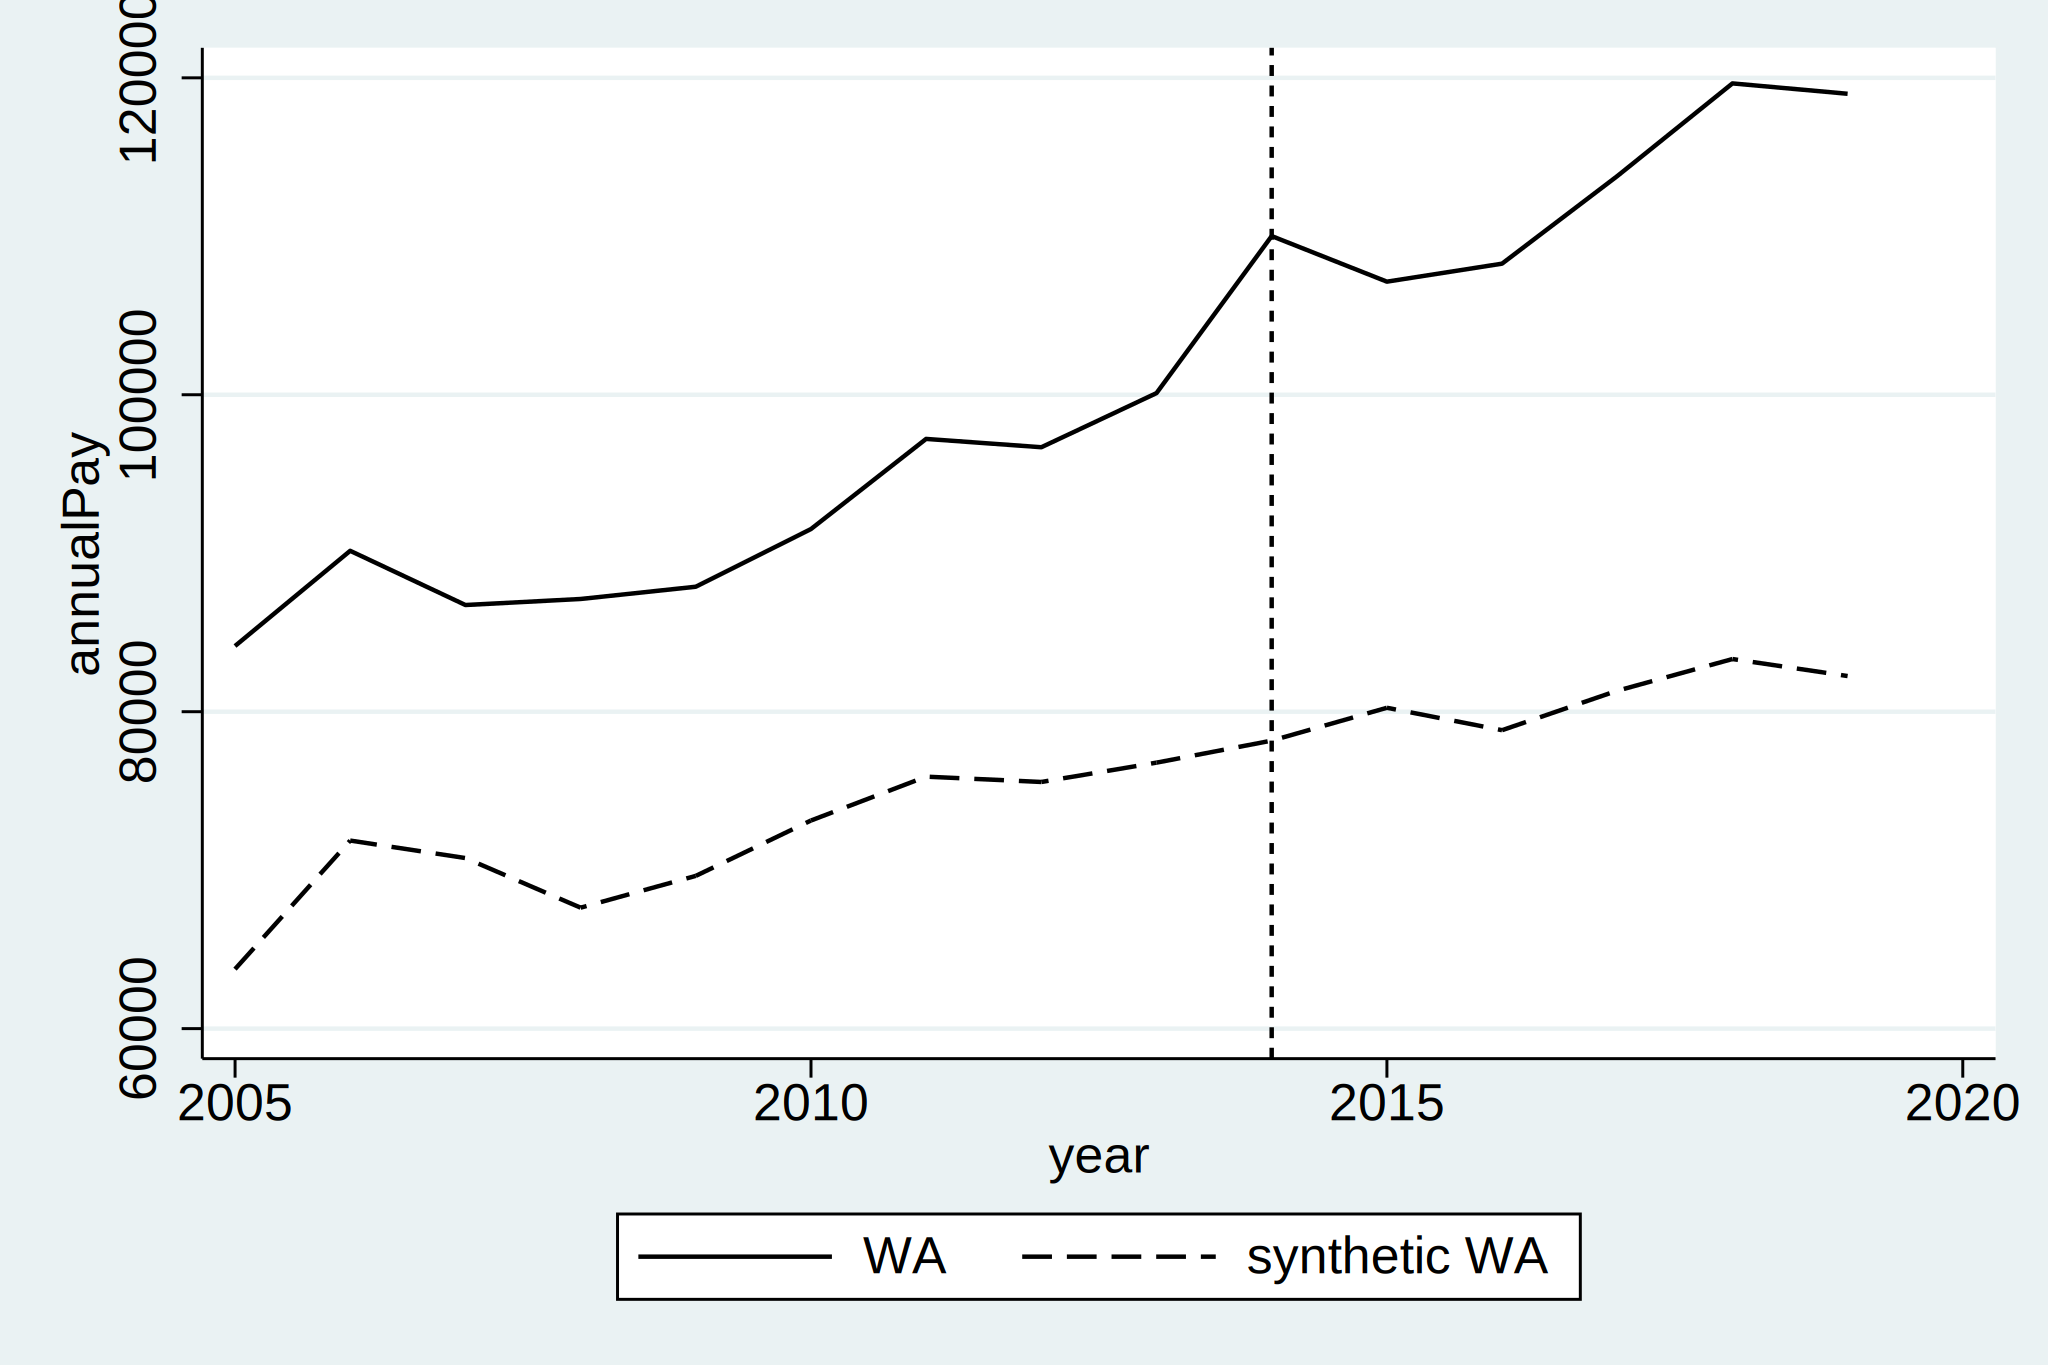

In [18]:
%%stata
synth annualPay ///
    employment(2010) employment(2011) employment(2012) employment(2013) ///
    annualPay(2010) annualPay(2011) lnAnnualPay(2012) annualPay(2013) ///
    unemploy(2010) unemploy(2011) unemploy(2012) unemploy(2013) ///
    pop(2010) pop(2011) pop(2012) pop(2013), ///
    trunit(53) trperiod(2014) unitnames(state) ///
    msperiod(2005(1)2013) resultsperiod(2005(1)2019) /// 
    replace ///
    figure


. /* Rename Graph */
. graph rename Graph synthWaAnnualPayLvl, replace
(note: graph synthWaAnnualPayLvl not found)

. 
. /*  Show the graph from the command above */
. graph display

. 


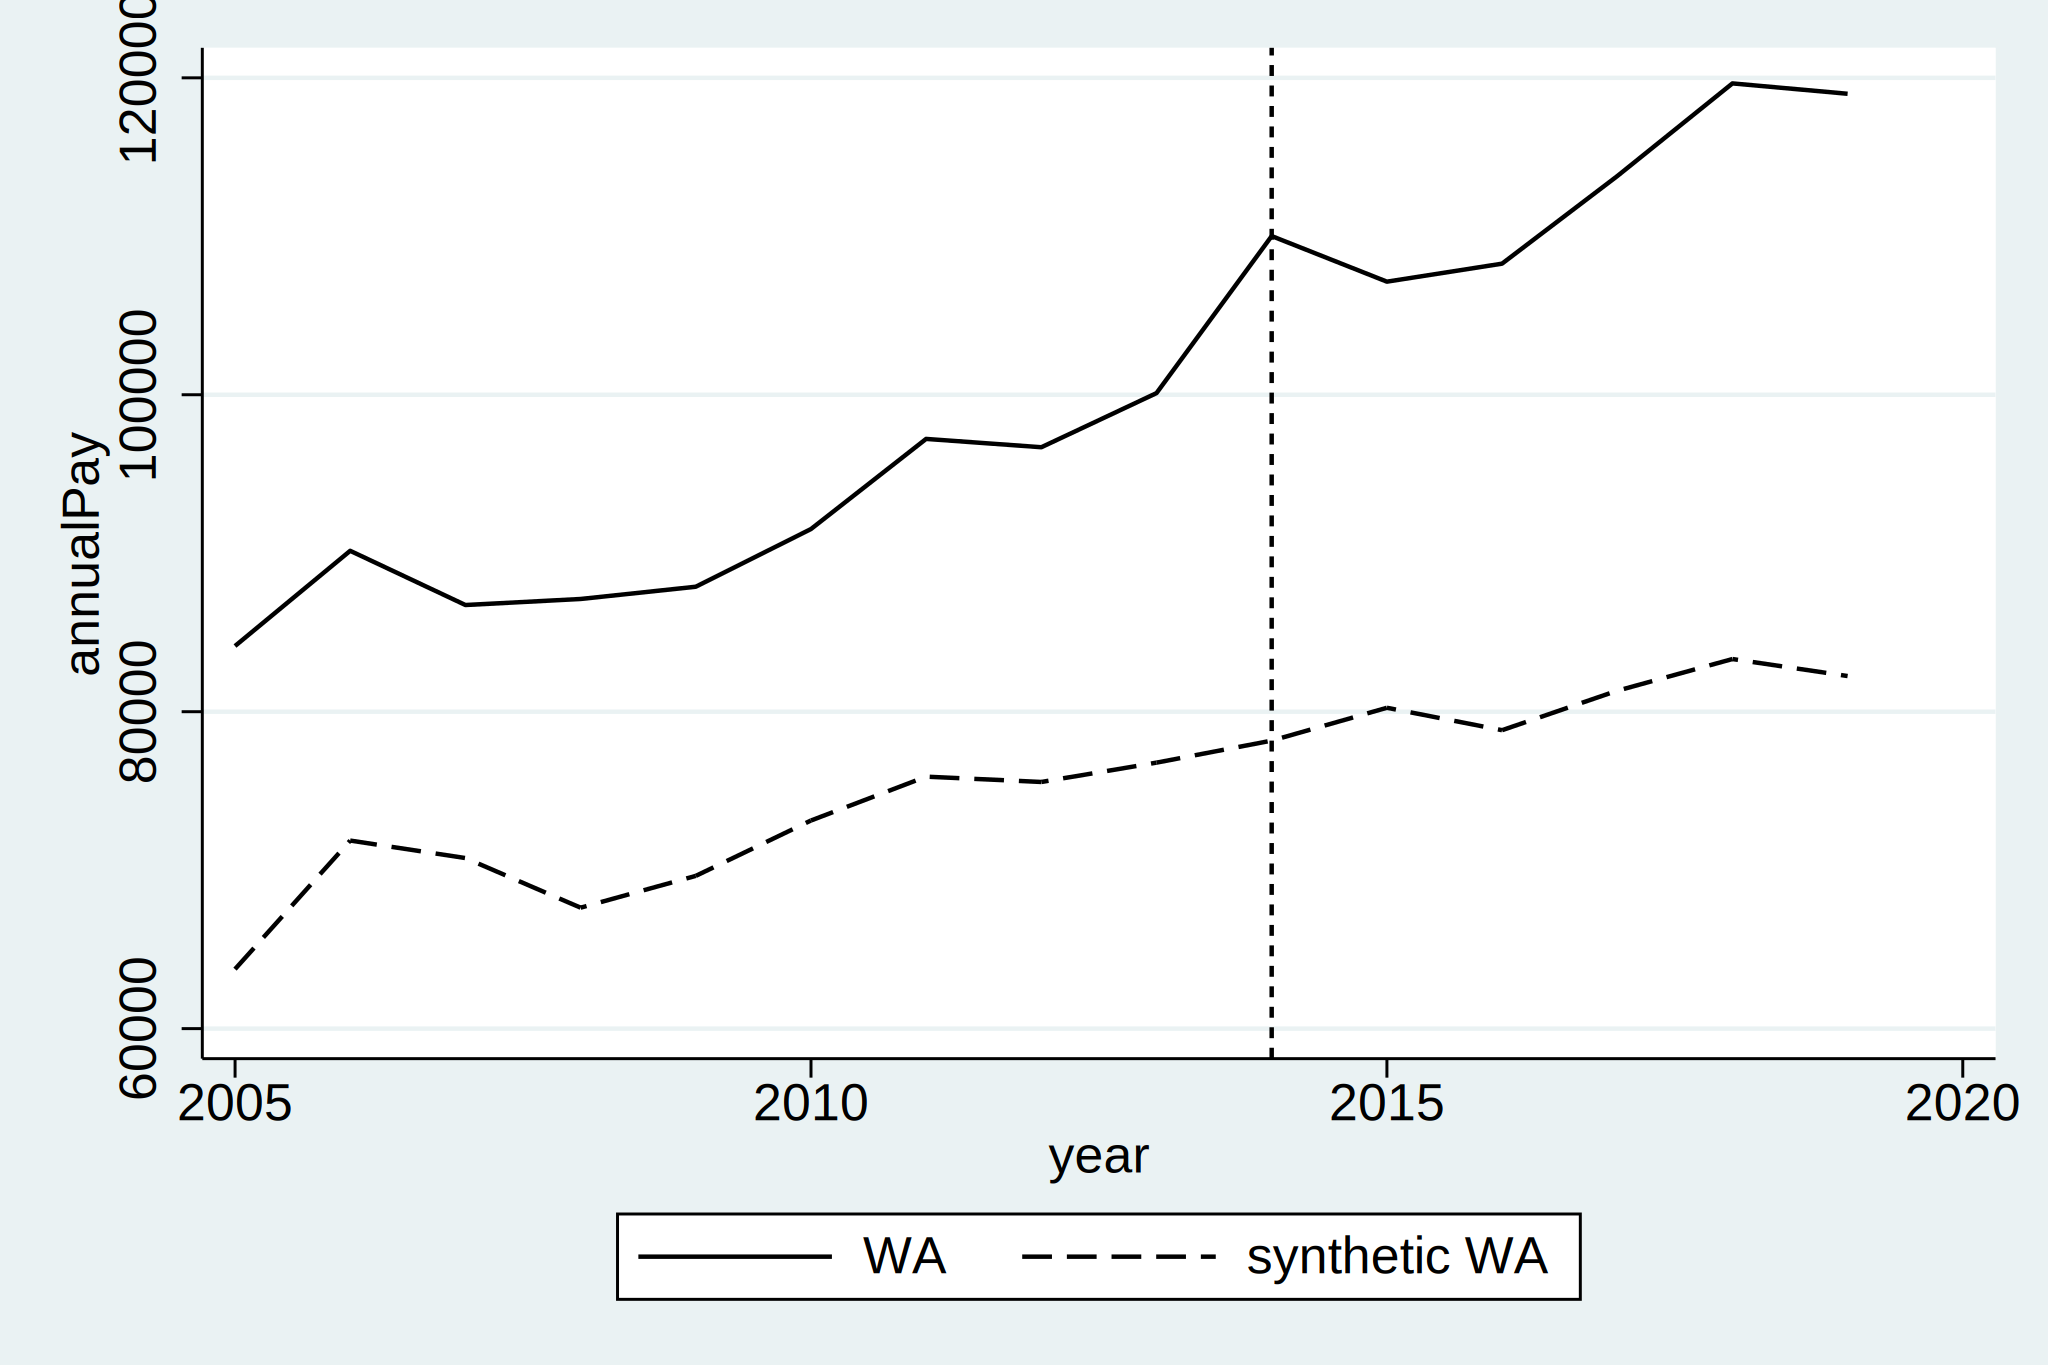

In [19]:
%%stata
/* Rename Graph */
graph rename Graph synthWaAnnualPayLvl, replace

/*  Show the graph from the command above */
graph display

### Combine Synthetic WA plots


. /* For Display */
. graph combine synthWaEmploymentLn synthWaAnnualPayLn, ///
>     rows(2) cols(1)

. 
. /* For File */
. graph export "$graphs/synthWaLn.png", replace
(file Output/Graphs/synthWaLn.png not found)
file Output/Graphs/synthWaLn.png written in PNG format

. 


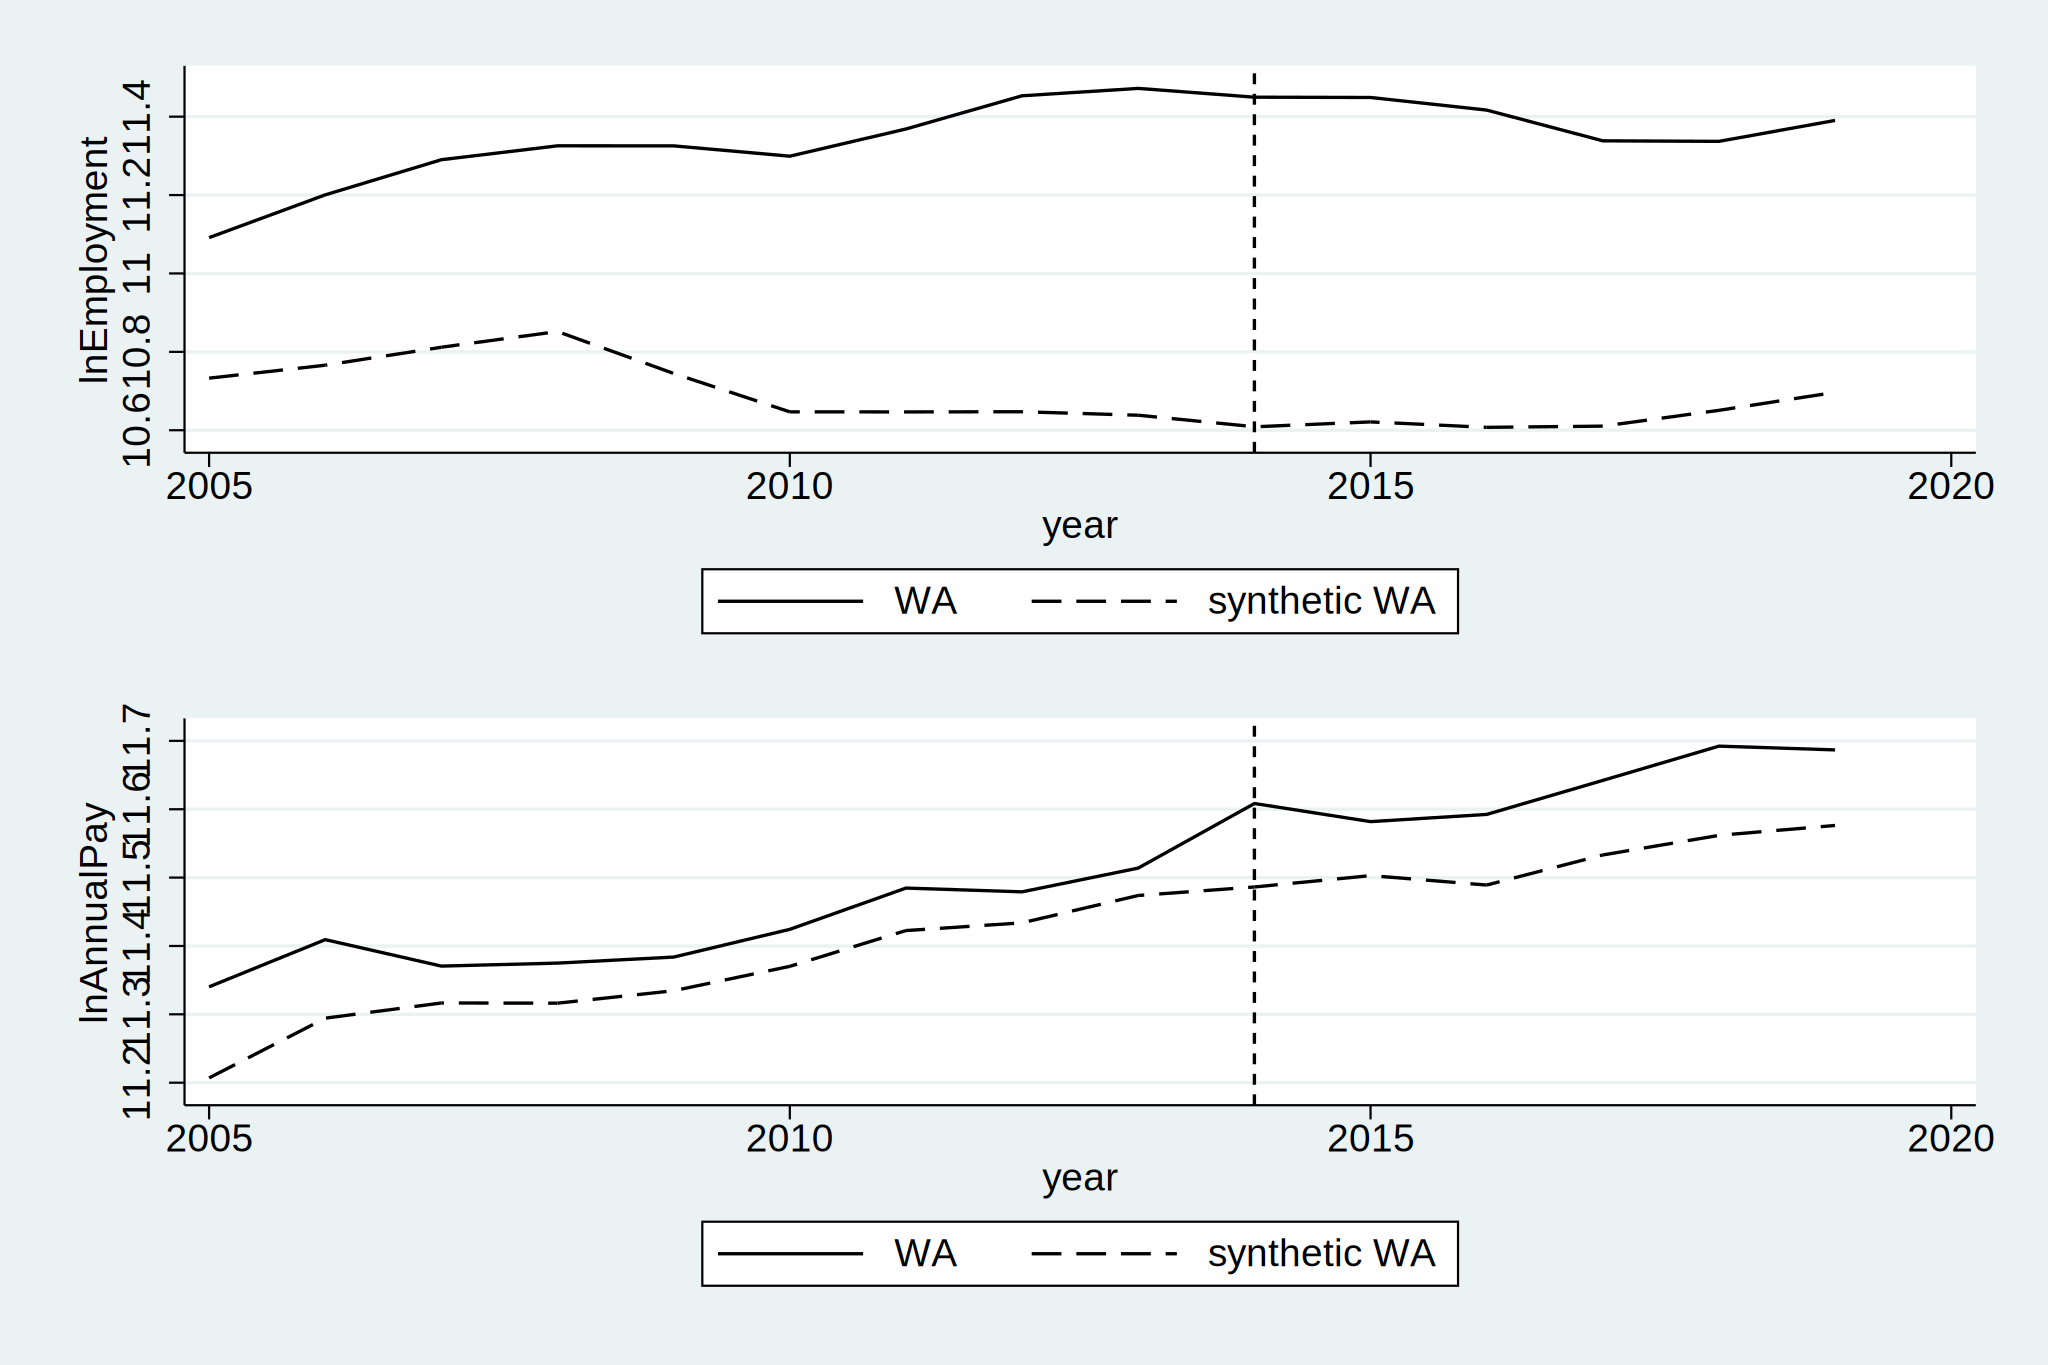

In [20]:
%%stata
/* For Display */
graph combine synthWaEmploymentLn synthWaAnnualPayLn, ///
    rows(2) cols(1)

/* For File */
graph export "$graphs/synthWaLn.png", replace


. /* For Display */
. graph combine synthWaEmploymentLvl synthWaAnnualPayLvl, ///
>     rows(2) cols(1)

. 
. /* For File */
. graph export "$graphs/synthWaLvl.png", replace
(file Output/Graphs/synthWaLvl.png not found)
file Output/Graphs/synthWaLvl.png written in PNG format

. 


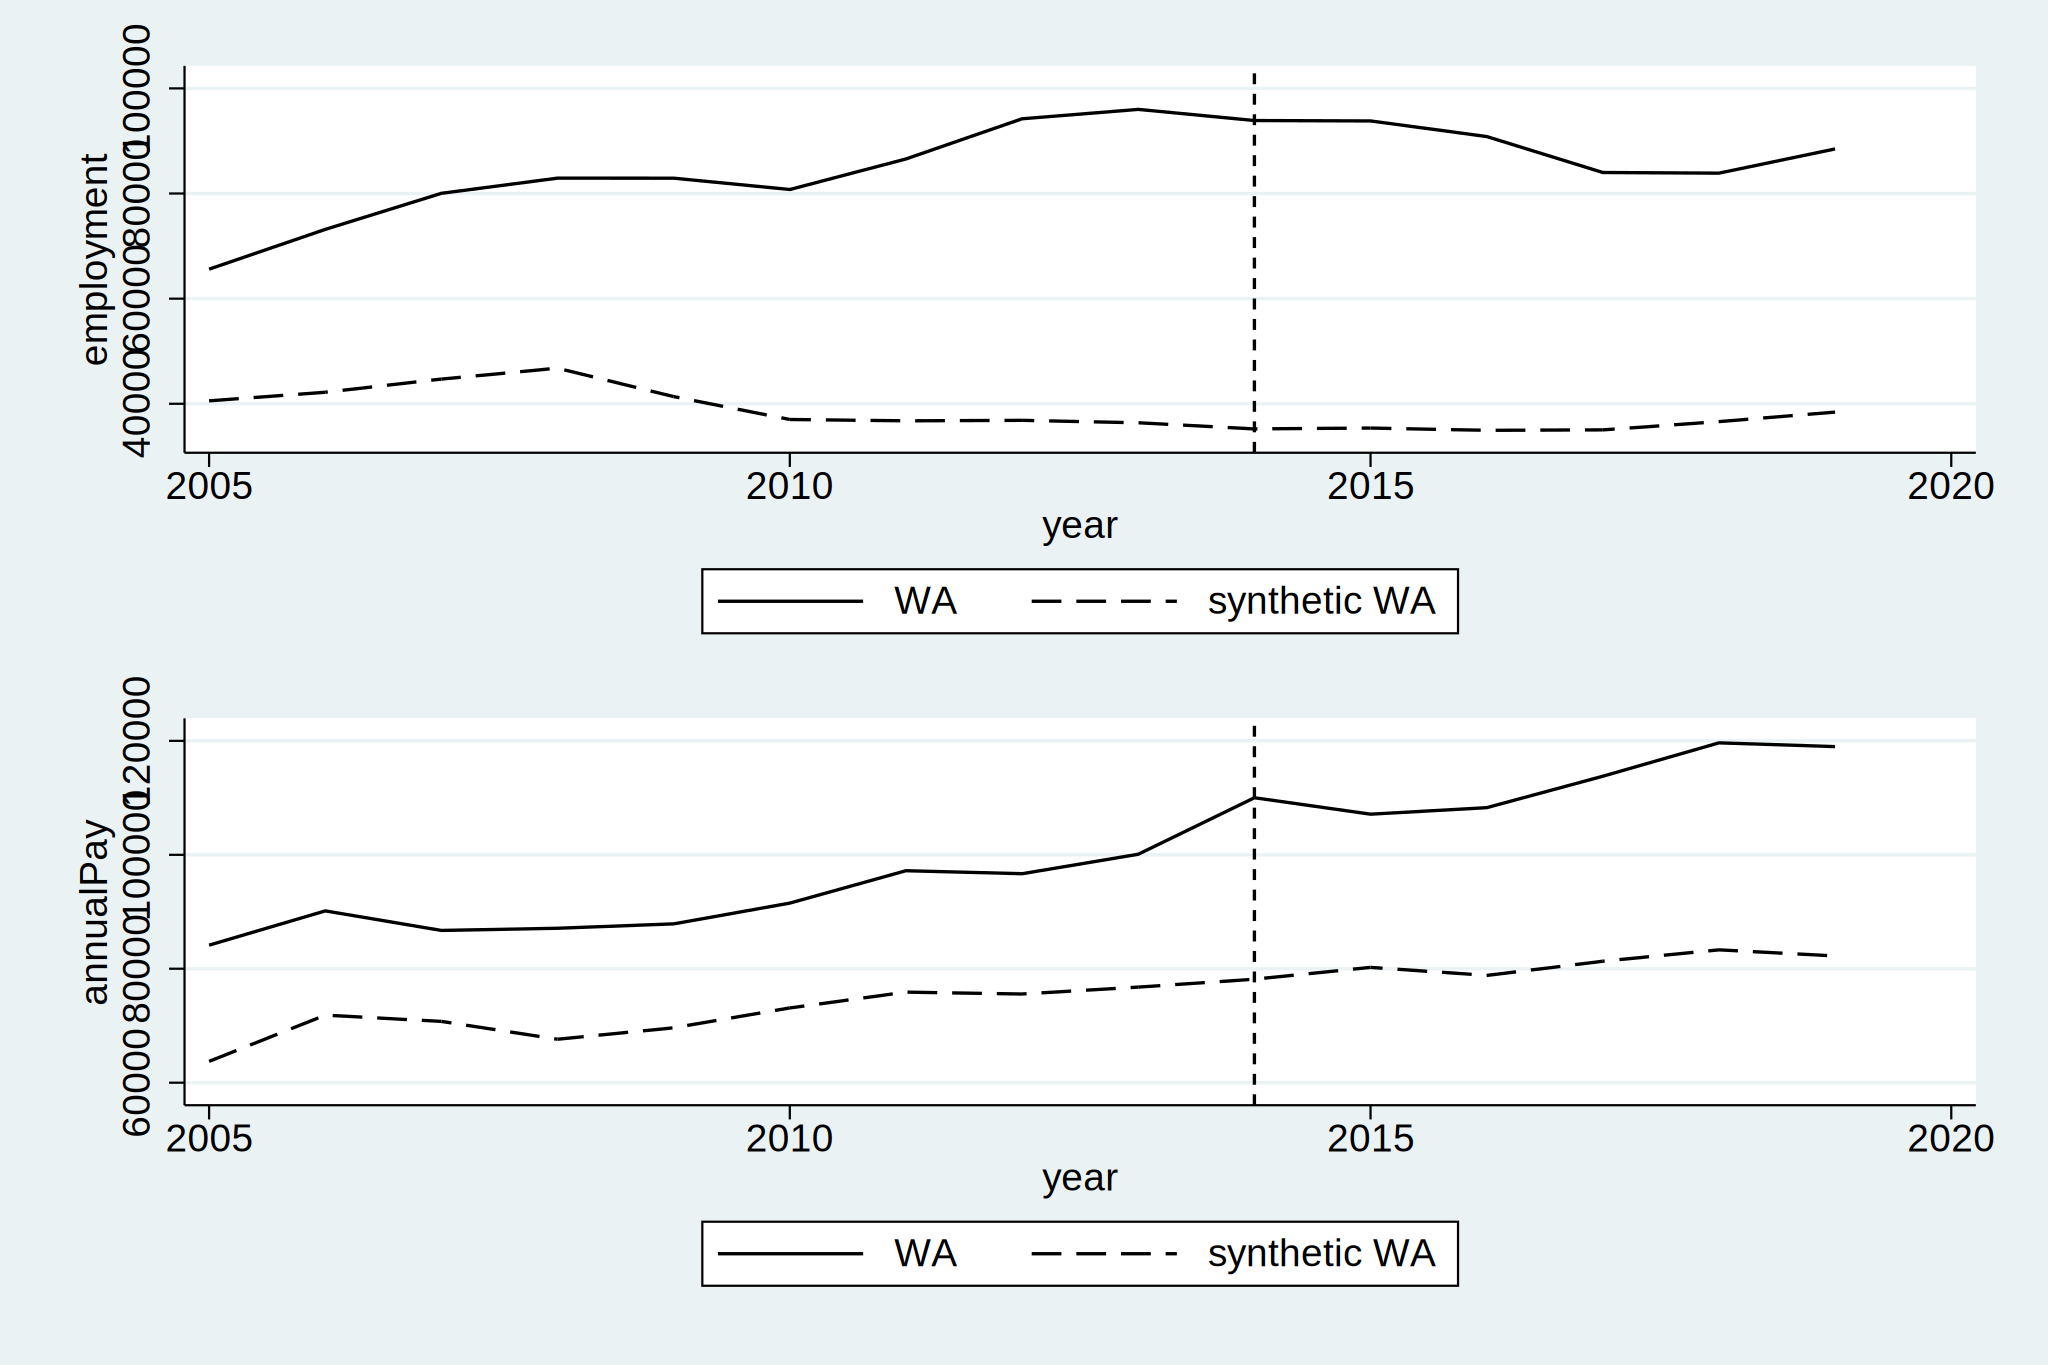

In [21]:
%%stata
/* For Display */
graph combine synthWaEmploymentLvl synthWaAnnualPayLvl, ///
    rows(2) cols(1)

/* For File */
graph export "$graphs/synthWaLvl.png", replace

In [22]:
%%capture
%%stata
clear
log close